# Global Forecasting with `sktime`

### Overview of this notebook

* introduction - global forecasting
* global forecast without exogeneous data
* global forecast with exogeneous data

In [6]:
import warnings

warnings.filterwarnings("ignore")

import sys

py_exe = sys.executable
!{py_exe} -m pip install pytorch_forecasting==1.0.0

### What is global forecast?

A lot of deep learning models will train on large dataset with many time series from many instances and predict on time series from other instances beyond training data. The ability to train on many series and predict beyond training data is called global forecast.

You have a training dataset containing $n$ time series $\{x_{i_1}, x_{i_2}, x_{i_3}, ..., x_{i_n}\}$ on which the forecaster is trained. During inference you have a set of $m$ time series, whereby $m$ need not be equal to $n$. And where there might or might not be intersection between the sets $\{i_1,.., i_n\}$ and $\{j_1, ... j_m\}$. For this set of time series $\{x_{j_1}, x_{j_2}, x_{j_3}, ..., x_{j_m}\}$ we then aim to provide forecasts.

To check the global forecast ability of one forecaster in sktime, you can check the `capability:global_forecasting` tag.

In [137]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingDeepAR

PytorchForecastingDeepAR().get_tag(
    "capability:global_forecasting"
)  # should return True

True

### Global Forecast without exogeneous data

You can pass $n$ series of `y` to `fit` and then predict on other $m$ series different from data in training. 

First we generate 500 series for training and 50 series to predict.

In [138]:
from sktime.utils._testing.hierarchical import _make_hierarchical

data = _make_hierarchical(
    hierarchy_levels=(5, 110), max_timepoints=10, min_timepoints=10, n_columns=1
)
l1 = data.index.get_level_values(1).map(lambda x: int(x[3:]))
y_train = data.loc[l1 < 100, "c0"].to_frame()
y_train.head(12)

c0
h0   h1   time                
h0_0 h1_0 2000-01-01  5.344600
          2000-01-02  5.385130
          2000-01-03  4.567360
          2000-01-04  5.285690
          2000-01-05  6.129614
          2000-01-06  3.811422
          2000-01-07  6.220975
          2000-01-08  3.488888
          2000-01-09  3.589005
          2000-01-10  5.958409
     h1_1 2000-01-01  5.201764
          2000-01-02  6.107488

`y_test` is the series we want to predict on which contains all historical values.

In [139]:
y_test = data.loc[l1 >= 100, "c0"].to_frame()
y_test.head(12)

c0
h0   h1     time                
h0_0 h1_100 2000-01-01  5.384317
            2000-01-02  3.512209
            2000-01-03  5.237926
            2000-01-04  4.629527
            2000-01-05  2.613302
            2000-01-06  3.792649
            2000-01-07  6.054258
            2000-01-08  4.583076
            2000-01-09  4.968127
            2000-01-10  4.640431
     h1_101 2000-01-01  5.654314
            2000-01-02  4.381005

Then we initialize a model to fit the data.

In [140]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats

model = PytorchForecastingNBeats(
    trainer_params={
        "max_epochs": 5,  # for quick test
        "limit_train_batches": 50,  # for quick test
    },
    dataset_params={
        "max_encoder_length": 3,
    },
)
print(model)

PytorchForecastingNBeats(dataset_params={'max_encoder_length': 3},
                         trainer_params={'limit_train_batches': 50,
                                         'max_epochs': 5})


In [141]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon([1, 2, 3], is_relative=True)
model.fit(y=y_train, fh=fh)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.375     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 15/15 [00:00<00:00, 31.62it/s, v_num=21, train_loss_step=0.904, val_loss=0.969, train_loss_epoch=0.958]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 15/15 [00:00<00:00, 29.34it/s, v_num=21, train_loss_step=0.904, val_loss=0.969, train_loss_epoch=0.958]


PytorchForecastingNBeats(dataset_params={'max_encoder_length': 3},
                         trainer_params={'limit_train_batches': 50,
                                         'max_epochs': 5})

Then we can predict on `y_test` which not included in `y_train`.

In [142]:
y_pred = model.predict(y=y_test, fh=fh)
y_pred.head(10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c0
h0   h1     time                
h0_0 h1_100 2000-01-11  4.840083
            2000-01-12  4.977394
            2000-01-13  5.064647
     h1_101 2000-01-11  5.140816
            2000-01-12  5.251262
            2000-01-13  5.325297
     h1_102 2000-01-11  4.864258
            2000-01-12  5.040134
            2000-01-13  5.150998
     h1_103 2000-01-11  5.007406

We can plot one series to see the result. As we are using random data and only train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='c0'>)

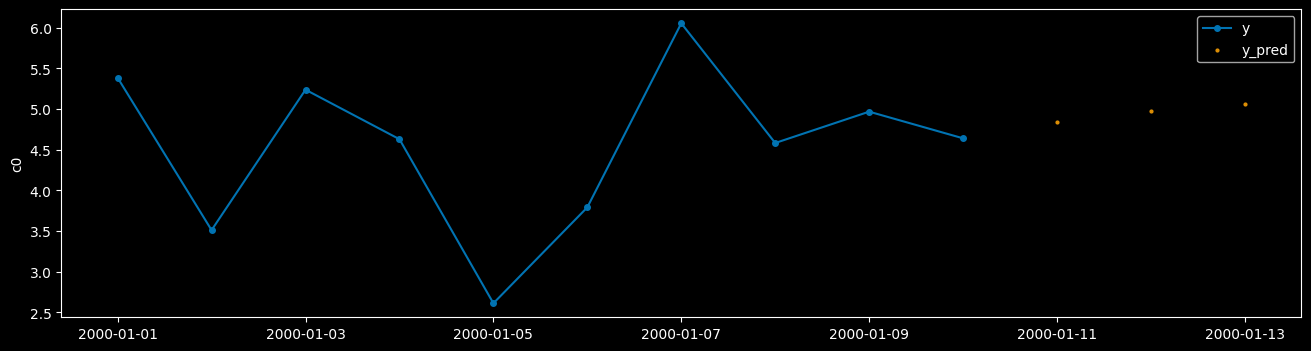

In [143]:
from sktime.utils.plotting import plot_series

plot_series(
    y_test.loc[("h0_0", "h1_100")],
    y_pred.loc[("h0_0", "h1_100")],
    labels=["y", "y_pred"],
)

### Global Forecast with exogeneous data

When we predict with exogeneous data, we need to pass both `X` and `y` to `predict`.

`X` must contain all historical values and the time points to be predicted while `y` should only contain the historical values but not the time points to be predicted.

In [144]:
data = _make_hierarchical(
    (5, 100),
    n_columns=2,
    max_timepoints=10,
    min_timepoints=10,
)
l1 = data.index.get_level_values(1).map(lambda x: int(x[3:]))
X_train = data.loc[l1 < 90, "c0"].to_frame()
y_train = data.loc[l1 < 90, "c1"].to_frame()
X_test = data.loc[l1 >= 80, "c0"].to_frame()
y_test = data.loc[l1 >= 80, "c1"].to_frame()
y_test = y_test.groupby(level=[0, 1]).apply(lambda x: x.droplevel([0, 1]).iloc[:-3])

`X_train` and `y_train` has the same time index.

In [145]:
X_train.head(12)

c0
h0   h1   time                
h0_0 h1_0 2000-01-01  5.161934
          2000-01-02  5.398771
          2000-01-03  4.238747
          2000-01-04  5.353835
          2000-01-05  2.237415
          2000-01-06  6.383368
          2000-01-07  3.936738
          2000-01-08  5.004550
          2000-01-09  4.389141
          2000-01-10  4.680426
     h1_1 2000-01-01  4.045219
          2000-01-02  4.441600

In [146]:
y_train.head(12)

c1
h0   h1   time                
h0_0 h1_0 2000-01-01  4.874364
          2000-01-02  3.229131
          2000-01-03  4.268050
          2000-01-04  3.594344
          2000-01-05  2.600294
          2000-01-06  5.075286
          2000-01-07  3.169445
          2000-01-08  3.280807
          2000-01-09  3.889109
          2000-01-10  2.462919
     h1_1 2000-01-01  3.750360
          2000-01-02  4.349581

`y_test` is shorter than `X_test` as `y_test` only contains the historical values not the time points to be predicted.

In [147]:
X_test.head(12)

c0
h0   h1    time                
h0_0 h1_80 2000-01-01  4.654932
           2000-01-02  5.434049
           2000-01-03  4.718527
           2000-01-04  3.958545
           2000-01-05  4.422221
           2000-01-06  5.216758
           2000-01-07  4.575687
           2000-01-08  5.068531
           2000-01-09  4.892554
           2000-01-10  5.780206
     h1_81 2000-01-01  4.570537
           2000-01-02  4.608686

In [148]:
y_test.head(12)

c1
h0   h1    time                
h0_0 h1_80 2000-01-01  3.786489
           2000-01-02  4.247371
           2000-01-03  3.246777
           2000-01-04  3.827141
           2000-01-05  5.361965
           2000-01-06  4.743557
           2000-01-07  4.015955
     h1_81 2000-01-01  5.028608
           2000-01-02  4.443011
           2000-01-03  4.639220
           2000-01-04  3.409193
           2000-01-05  4.384253

Let's initialize a model and fit the data.

In [149]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingTFT

In [150]:
model = PytorchForecastingTFT(
    trainer_params={
        "max_epochs": 5,  # for quick test
        "limit_train_batches": 10,  # for quick test
    },
    dataset_params={
        "max_encoder_length": 3,
    },
)
print(model)

PytorchForecastingTFT(dataset_params={'max_encoder_length': 3},
                      trainer_params={'limit_train_batches': 10,
                                      'max_epochs': 5})


In [151]:
model.fit(y=y_train, X=X_train, fh=fh)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'max_encoder_length': 3, 'output_size': 7}



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 32    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 18.51it/s, v_num=23, train_loss_step=0.799, val_loss=0.800, train_loss_epoch=0.833]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 17.60it/s, v_num=23, train_loss_step=0.799, val_loss=0.800, train_loss_epoch=0.833]


PytorchForecastingTFT(dataset_params={'max_encoder_length': 3},
                      trainer_params={'limit_train_batches': 10,
                                      'max_epochs': 5})

Now we can predict on `y_test` with `X_test`.

In [152]:
y_pred = model.predict(fh=fh, X=X_test, y=y_test)
y_pred.head(10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c1
h0   h1    time                
h0_0 h1_80 2000-01-08  3.850976
           2000-01-09  3.817626
           2000-01-10  4.060377
     h1_81 2000-01-08  3.947010
           2000-01-09  4.081046
           2000-01-10  4.585935
     h1_82 2000-01-08  3.983865
           2000-01-09  3.829445
           2000-01-10  4.117847
     h1_83 2000-01-08  3.847155

We can plot one series to see the result. As we are using random data and only train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='c1'>)

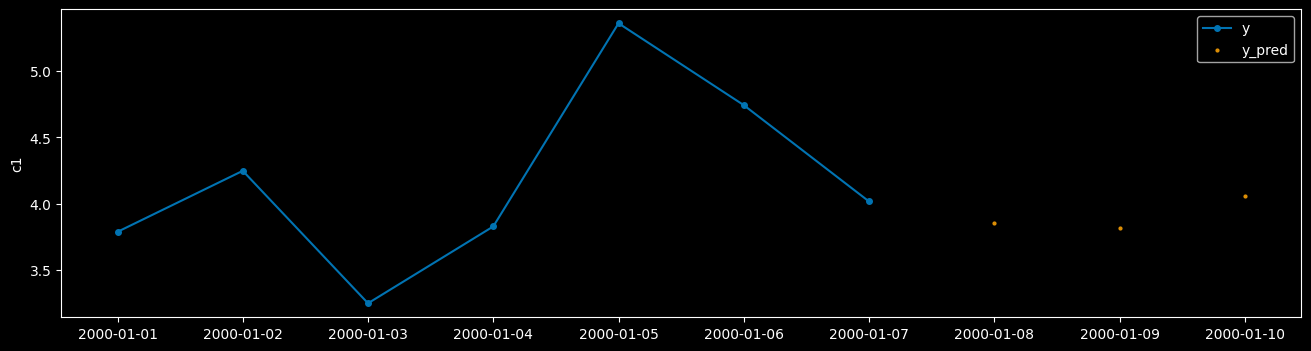

In [153]:
plot_series(
    y_test.loc[("h0_0", "h1_80")],
    y_pred.loc[("h0_0", "h1_80")],
    labels=["y", "y_pred"],
)